In [20]:
NAME = 'base-tabiturient'

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

In [22]:
import datetime

In [23]:
import mydata as md

data = md.Data('cache')


In [24]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('tabiturient')

In [50]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=3,
    output_sequence_length=sequence_length
)

In [51]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-08 23:57:43.514461: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [53]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [54]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=False
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,355 (4.90 MB)

 Trainable params: 1,284,355 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")}"

epochs = 20
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.4556 - f1_score: 0.2774 - loss: 1.0565 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 1.0082
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4896 - f1_score: 0.2280 - loss: 1.0324 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 1.0012
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.4890 - f1_score: 0.2290 - loss: 1.0271 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9927
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5041 - f1_score: 0.2414 - loss: 1.0180 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9844
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5069 - f1_score: 0.2664 - loss: 1.0124 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9706
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5128 - f1_score: 0.2902 - loss: 1.0069 - val_accuracy: 0.5181 - val_f1_score: 

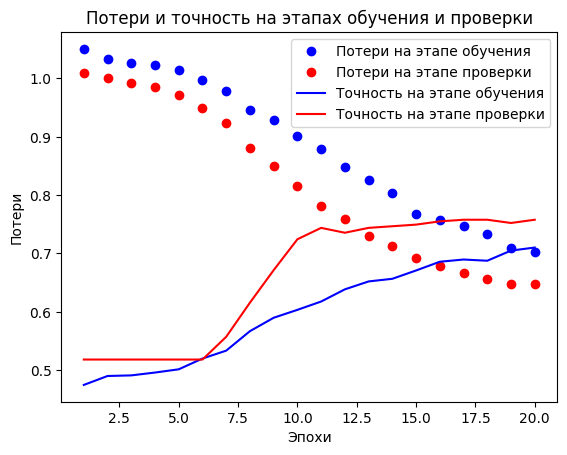

In [57]:
data.plot(history)

In [58]:
model.load_weights(checkpoint_filepath)

In [59]:
model.evaluate(test_ds_batch)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.7172 - f1_score: 0.5226 - loss: 0.7232


[0.6979658007621765, 0.7277777791023254, 0.5355648994445801]

In [18]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │     1,284,355 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,355 (4.90 MB)

 Trainable params: 1,284,355 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
export_model.save(f"models/export-model-{NAME}.keras")